In [1]:
from pathlib import Path

# Корневая папка проекта
PROJECT_ROOT = Path(r"E:\work\mvp_ultrasound")

# Путь к исходным данным (где лежат папки train / validation / test)
DATA_RAW = PROJECT_ROOT / r"data\raw\Ultrasound Fetus Dataset\Ultrasound Fetus Dataset\Data\Data"

print("PROJECT_ROOT exists:", PROJECT_ROOT.exists())
print("DATA_RAW exists:", DATA_RAW.exists())

# Посмотрим, какие подпапки есть
if DATA_RAW.exists():
    for p in DATA_RAW.iterdir():
        print("📁", p.name)
else:
    print("⚠️ Папка с данными не найдена — нужно проверить путь!")

PROJECT_ROOT exists: True
DATA_RAW exists: True
📁 Datasets
📁 FetusDataset.csv
📁 OverlayedImages
📁 Resnet_fineTuning.pth
📁 test
📁 train
📁 validation


In [2]:
from pprint import pprint

# Составим словарь: {split_name: [список папок классов]}
subdirs = {}

for split in ["train", "validation", "test"]:
    split_path = DATA_RAW / split
    if not split_path.exists():
        print(f"⚠️ Папка {split} не найдена")
        continue

    class_folders = [p.name for p in split_path.iterdir() if p.is_dir()]
    subdirs[split] = class_folders

pprint(subdirs)

{'test': ['benign', 'malignant', 'normal'],
 'train': ['benign', 'malignant', 'normal'],
 'validation': ['benign', 'malignant', 'normal']}


Matplotlib is building the font cache; this may take a moment.


Классы (train): ['benign', 'malignant', 'normal']
Класс для превью: benign, найдено изображений: 241


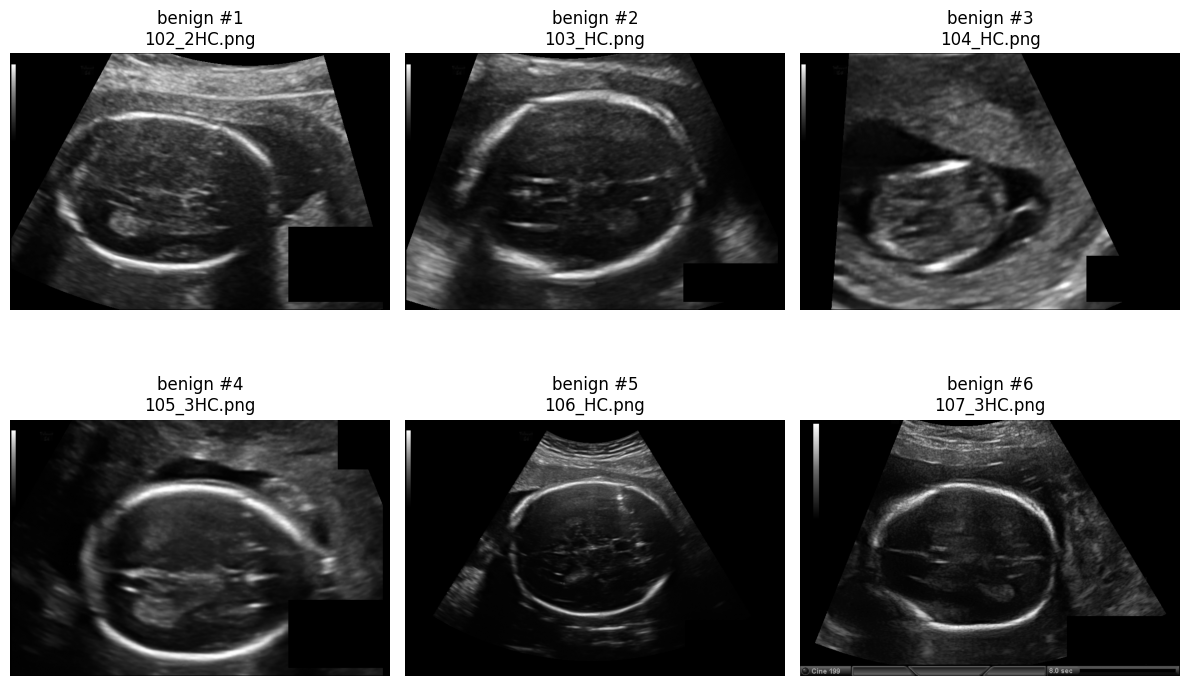

In [3]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Папка train/ и первый класс для примера
train_dir = DATA_RAW / "train"
class_dirs = sorted([d for d in train_dir.iterdir() if d.is_dir()])
print("Классы (train):", [d.name for d in class_dirs])

# Возьмём первую папку (например, benign)
some_class = class_dirs[0]
images = sorted([p for p in some_class.rglob("*") if p.suffix.lower() in [".jpg", ".jpeg", ".png"]])

print(f"Класс для превью: {some_class.name}, найдено изображений: {len(images)}")

# Отображаем первые 6
n = min(6, len(images))
plt.figure(figsize=(12, 8))
for i in range(n):
    img = cv2.imread(str(images[i]), cv2.IMREAD_GRAYSCALE)  # читаем как ч/б
    if img is None:
        continue
    plt.subplot(2, 3, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"{some_class.name} #{i+1}\n{images[i].name}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [4]:
import statistics

heights, widths = [], []

# Возьмём небольшую выборку — до 50 изображений из каждого класса (train)
for cls_dir in class_dirs:
    imgs = sorted([p for p in cls_dir.rglob("*") if p.suffix.lower() in [".jpg", ".jpeg", ".png"]])[:50]
    for p in imgs:
        img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            h, w = img.shape[:2]
            heights.append(h)
            widths.append(w)

print("Примерные размеры:")
print("  Средняя высота:", round(statistics.mean(heights), 1), "±", round(statistics.pstdev(heights), 1))
print("  Средняя ширина:", round(statistics.mean(widths), 1), "±", round(statistics.pstdev(widths), 1))
print("  Проверено изображений:", len(heights))

Примерные размеры:
  Средняя высота: 540.1 ± 0.5
  Средняя ширина: 799.7 ± 1.7
  Проверено изображений: 150


In [5]:
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

for split in ["train", "validation", "test"]:
    (DATA_PROCESSED / split).mkdir(parents=True, exist_ok=True)

print("Папка для обработанных данных:", DATA_PROCESSED)
print("Содержимое data/:")
for p in (PROJECT_ROOT / "data").iterdir():
    print("📁", p.name)

Папка для обработанных данных: E:\work\mvp_ultrasound\data\processed
Содержимое data/:
📁 annotations
📁 processed
📁 raw
📁 README.md


In [6]:
import shutil

TARGET_SIZE = (256, 256)  # уменьшаем до 256x256 для стабильности на CPU

def collect_images(root):
    result = {}
    for split in ["train", "validation", "test"]:
        split_dir = root / split
        if not split_dir.exists():
            continue
        class_dirs = sorted([d for d in split_dir.iterdir() if d.is_dir()])
        result[split] = {}
        for cdir in class_dirs:
            imgs = sorted([p for p in cdir.rglob("*") if p.suffix.lower() in [".jpg", ".jpeg", ".png"]])
            result[split][cdir.name] = imgs
    return result


data_index = collect_images(DATA_RAW)

# создадим подпапки классов
for split, classes in data_index.items():
    for cls_name in classes.keys():
        (DATA_PROCESSED / split / cls_name).mkdir(parents=True, exist_ok=True)

count_saved = 0
for split, classes in data_index.items():
    for cls_name, paths in classes.items():
        for p in paths[:50]:  # берём только первые 50 для теста
            img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            resized = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)
            out_path = DATA_PROCESSED / split / cls_name / (p.stem + ".png")
            cv2.imwrite(str(out_path), resized)
            count_saved += 1

print("✅ Готово. Сохранено файлов:", count_saved)

✅ Готово. Сохранено файлов: 436


Примеров для превью: 18


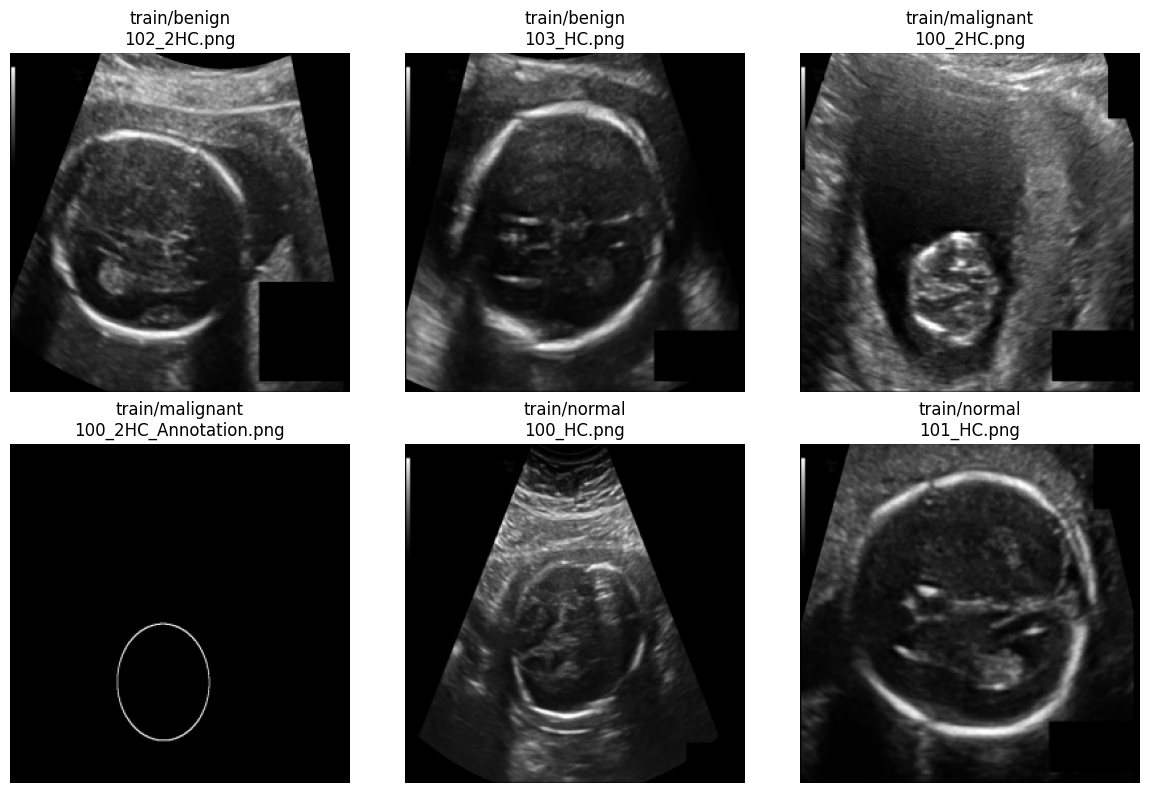

In [7]:
from itertools import islice
import random
random.seed(42)

samples = []
for split in ["train", "validation", "test"]:
    for cls_dir in (DATA_PROCESSED / split).iterdir():
        if cls_dir.is_dir():
            imgs = sorted([p for p in cls_dir.iterdir() if p.suffix.lower() == ".png"])
            samples.extend(imgs[:2])  # по 2 изображения с каждого класса

print("Примеров для превью:", len(samples))

plt.figure(figsize=(12, 8))
for i, p in enumerate(islice(samples, 6)):
    img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"{p.parent.parent.name}/{p.parent.name}\n{p.name}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [8]:
import os

def is_valid_ultrasound(img):
    """Фильтруем черные/масочные изображения."""
    # Если средняя яркость меньше 10 — считаем изображение пустым/чёрным
    mean_intensity = np.mean(img)
    return mean_intensity > 10

filtered_count = 0
removed_count = 0

for split in ["train", "validation", "test"]:
    for cls_dir in (DATA_PROCESSED / split).iterdir():
        if not cls_dir.is_dir():
            continue
        for p in list(cls_dir.iterdir()):
            if p.suffix.lower() != ".png":
                continue
            img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            if not is_valid_ultrasound(img):
                p.unlink()  # удаляем из processed
                removed_count += 1
            else:
                filtered_count += 1

print(f"✅ Фильтрация завершена. Осталось изображений: {filtered_count}, удалено: {removed_count}")

✅ Фильтрация завершена. Осталось изображений: 359, удалено: 77


In [9]:
import pandas as pd

records = []

for split in ["train", "validation", "test"]:
    for cls_dir in (DATA_PROCESSED / split).iterdir():
        if not cls_dir.is_dir():
            continue
        label = cls_dir.name
        for p in cls_dir.iterdir():
            if p.suffix.lower() == ".png":
                records.append({
                    "split": split,
                    "path": str(p),
                    "label": label
                })

df = pd.DataFrame(records)
print("✅ CSV сформирован.")
print("Размер:", df.shape)
print(df.head())

# Сохраним CSV
csv_path = DATA_PROCESSED / "dataset_index.csv"
df.to_csv(csv_path, index=False)
print("\n📁 CSV сохранён по пути:", csv_path)

✅ CSV сформирован.
Размер: (359, 3)
   split                                               path   label
0  train  E:\work\mvp_ultrasound\data\processed\train\be...  benign
1  train  E:\work\mvp_ultrasound\data\processed\train\be...  benign
2  train  E:\work\mvp_ultrasound\data\processed\train\be...  benign
3  train  E:\work\mvp_ultrasound\data\processed\train\be...  benign
4  train  E:\work\mvp_ultrasound\data\processed\train\be...  benign

📁 CSV сохранён по пути: E:\work\mvp_ultrasound\data\processed\dataset_index.csv
